In [ ]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv("/content/drive/My Drive/10hr.csv",engine='python')
data['Date'] = pd.to_datetime(data['Date']) 
data.tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,RT
715,2020-11-20,24.7
716,2020-01-12,99.8
717,2020-10-12,86.5
718,2020-12-20,62.4
719,2020-12-31,107.5


Text(0.5, 0, 'Date')

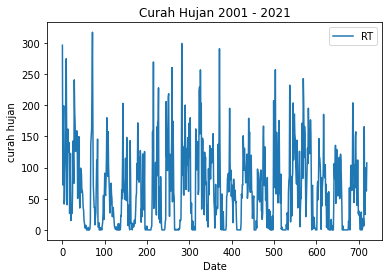

In [ ]:
import matplotlib.pyplot as plt
data.plot(y ='RT')
plt.title('Curah Hujan 2001 - 2021')
plt.ylabel('curah hujan')
plt.xlabel('Date')


In [ ]:
# normalize the dataset
dataset=data['RT'].values
dataset=dataset.astype('float32')
dataset=numpy.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train_size)
print(test_size)

503
217


In [ ]:
#Create Dataset Function
def create_dataset(dataset,look_back):
  X,Y=[],[]
  for i in range (len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    X.append(a)
    Y.append(dataset[i+look_back,0])
  return numpy.array(X),numpy.array(Y)

# reshape into X=t and Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

learning_rate=0.01
batch_size=10
neuron_unit=5

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(neuron_unit, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1,activation='tanh',kernel_initializer='glorot_uniform',bias_initializer='zero',use_bias=True))
opt=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=opt)
history=model.fit(trainX, trainY, epochs=50, batch_size=batch_size, validation_data=(testX,testY),
          callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=2, shuffle=False)
model.reset_states()
model.summary()

Epoch 1/50
48/48 - 3s - loss: 0.0425 - val_loss: 0.0261 - 3s/epoch - 53ms/step
Epoch 2/50
48/48 - 0s - loss: 0.0278 - val_loss: 0.0218 - 412ms/epoch - 9ms/step
Epoch 3/50
48/48 - 0s - loss: 0.0244 - val_loss: 0.0203 - 428ms/epoch - 9ms/step
Epoch 4/50
48/48 - 0s - loss: 0.0233 - val_loss: 0.0198 - 452ms/epoch - 9ms/step
Epoch 5/50
48/48 - 0s - loss: 0.0226 - val_loss: 0.0195 - 434ms/epoch - 9ms/step
Epoch 6/50
48/48 - 0s - loss: 0.0223 - val_loss: 0.0193 - 429ms/epoch - 9ms/step
Epoch 7/50
48/48 - 0s - loss: 0.0221 - val_loss: 0.0192 - 434ms/epoch - 9ms/step
Epoch 8/50
48/48 - 0s - loss: 0.0220 - val_loss: 0.0191 - 450ms/epoch - 9ms/step
Epoch 9/50
48/48 - 0s - loss: 0.0219 - val_loss: 0.0191 - 413ms/epoch - 9ms/step
Epoch 10/50
48/48 - 0s - loss: 0.0218 - val_loss: 0.0191 - 417ms/epoch - 9ms/step
Epoch 11/50
48/48 - 0s - loss: 0.0217 - val_loss: 0.0191 - 411ms/epoch - 9ms/step
Epoch 12/50
48/48 - 0s - loss: 0.0217 - val_loss: 0.0191 - 428ms/epoch - 9ms/step
Epoch 13/50
48/48 - 0s - lo

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
model.reset_states()
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



6/6 [==============================] - 0s 3ms/step


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
print(testY.shape)

(1, 192)


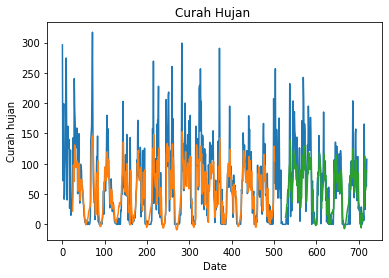

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Curah Hujan ')
plt.xlabel('Date')
plt.ylabel('Curah hujan')
plt.show()

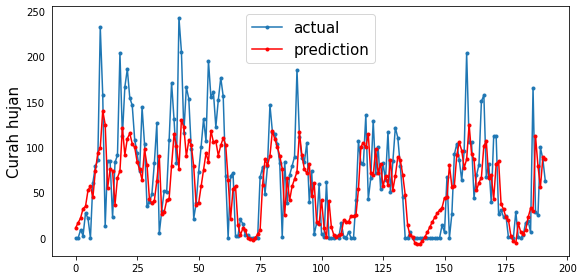

In [ ]:
#Plot Prediction
aa=[x for x in range(192)]
plt.figure(figsize=(8,4))
plt.plot(aa,testY[0][:192],marker='.',label="actual")
plt.plot(aa,testPredict[:,0][:192],'r',marker='.',label="prediction")
plt.tick_params(left=False,labelleft=True) #remove ticks
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Curah hujan',size=15)
plt.legend(fontsize=15)
plt.show()



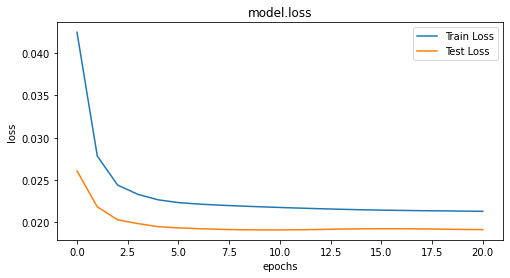

In [ ]:
#Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model.loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
X_FUTURE = 12
predictions = numpy.array([])
last = testX[-1]
for i in range(X_FUTURE):
  curr_prediction = model.predict(numpy.array([last]))
  last = numpy.concatenate([last[1:], curr_prediction])
  predictions = numpy.concatenate([predictions, curr_prediction[0]])
predictions = scaler.inverse_transform([predictions])[0]
print(predictions)

1/1 [==============================] - 0s 17ms/step
[87.46949231 84.72997788 80.12737136 74.83700862 69.4009598  64.16055143
 59.33449218 54.88761743 50.80385219 47.06352562 43.66733232 40.62006834]
